<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/break_out_acq_and_appeals_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pymc-labs/pymc-marketing.git

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-nn7gm1x6
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-nn7gm1x6
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit ad393b89fd77768a5a8290b0544c435fb40f584d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install numpyro


In [3]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import numpyro

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


In [4]:
import pymc_marketing
print(pymc_marketing.__version__)

0.11.1


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [7]:
# Hard-code a list of the actual Giving Tuesday dates for 2022, 2023, 2024
giving_tuesday_dates = [
    pd.Timestamp('2022-11-29'),
    pd.Timestamp('2023-11-28'),
    pd.Timestamp('2024-12-03'),
]


sales = pd.read_csv(path_+'cafb_donations_thru_2024.csv', parse_dates=['Date'], index_col=['Date'])

# Access the index using 'sales.index' instead of 'sales["Date"]'
sales["eoy_campaign"] = sales.index.month.isin([11, 12]).astype(int)
sales["end_of_year"] = ((sales.index.month == 12) & (sales.index.day == 31)).astype(int)

# ... (rest of your code) ...

# Use sales.index instead of sales['Date'] to access the index
sales['giving_tuesday'] = sales.index.isin(giving_tuesday_dates).astype(int)

sales = sales.resample('W').sum()

In [8]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
#
#dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm_acq = pd.read_csv(path_+'dm_acquisition.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm_appeals = pd.read_csv(path_+'dm_appeal.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
#sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
#remove v2 from excel file name
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()
ga4 = pd.read_csv(path_+'cafb_ga4_sessions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})


In [9]:
consumer_demand = pd.read_excel(path_+'Economic Data_v3.xlsx', sheet_name='Consumer_Demand', index_col=None)
consumer_demand = consumer_demand.set_index('Date')
consumer_demand.tail()

,Consumer_Demand
Date,
2025-01-26,14
2025-02-02,26
2025-02-09,25
2025-02-16,18
2025-02-23,21


In [10]:
df = pd.concat([bing, dm_acq, dm_appeals, email, fb, paid_search, prog, ftf ,sales, consumer_demand], axis=1).fillna(0).head(144).reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.head(2)

,Date,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Acq_Impressions,DM_Acq_Spend,DM_Appeal_Impressions,DM_Appeal_Spend,Email_Impressions,...,Programatic_Spend,Programatic_Impressions,FTF_Spend,FTF_Impressions,contacts,Revenue,eoy_campaign,end_of_year,giving_tuesday,Consumer_Demand
0,2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30822.72,0.0,0.0,0.0,0.0
1,2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3036.0,6487.0,561.0,68907.69,0.0,0.0,0.0,28.0


In [11]:
df['GoogleAds_Impressions'] = df['GoogleAds_Branded_Impressions'] + df['GoogleAds_NonBranded_Impressions']
df['GoogleAds_Spend'] = df['GoogleAds_Branded_Spend'] + df['GoogleAds_NonBranded_Spend']

df['Bing_Impressions'] = df['Bing_Branded_Impressions'] + df['Bing_NonBranded_Impressions']
df['Bing_Spend'] = df['Bing_Branded_Spend'] + df['Bing_NonBranded_Spend']

In [12]:
df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
df["end_of_year"] = ((df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)) | ((df["Date"].dt.month == 1) & (df["Date"].dt.day == 1))
#df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")
#fix trend
df['trend'] = df['Consumer_Demand']


In [13]:
df['log_Revenue'] = np.log(df['Revenue'] + 1)


In [14]:
df['end_of_year'].sum()

2

<ipython-input-15-1a5ac69e9fc7>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


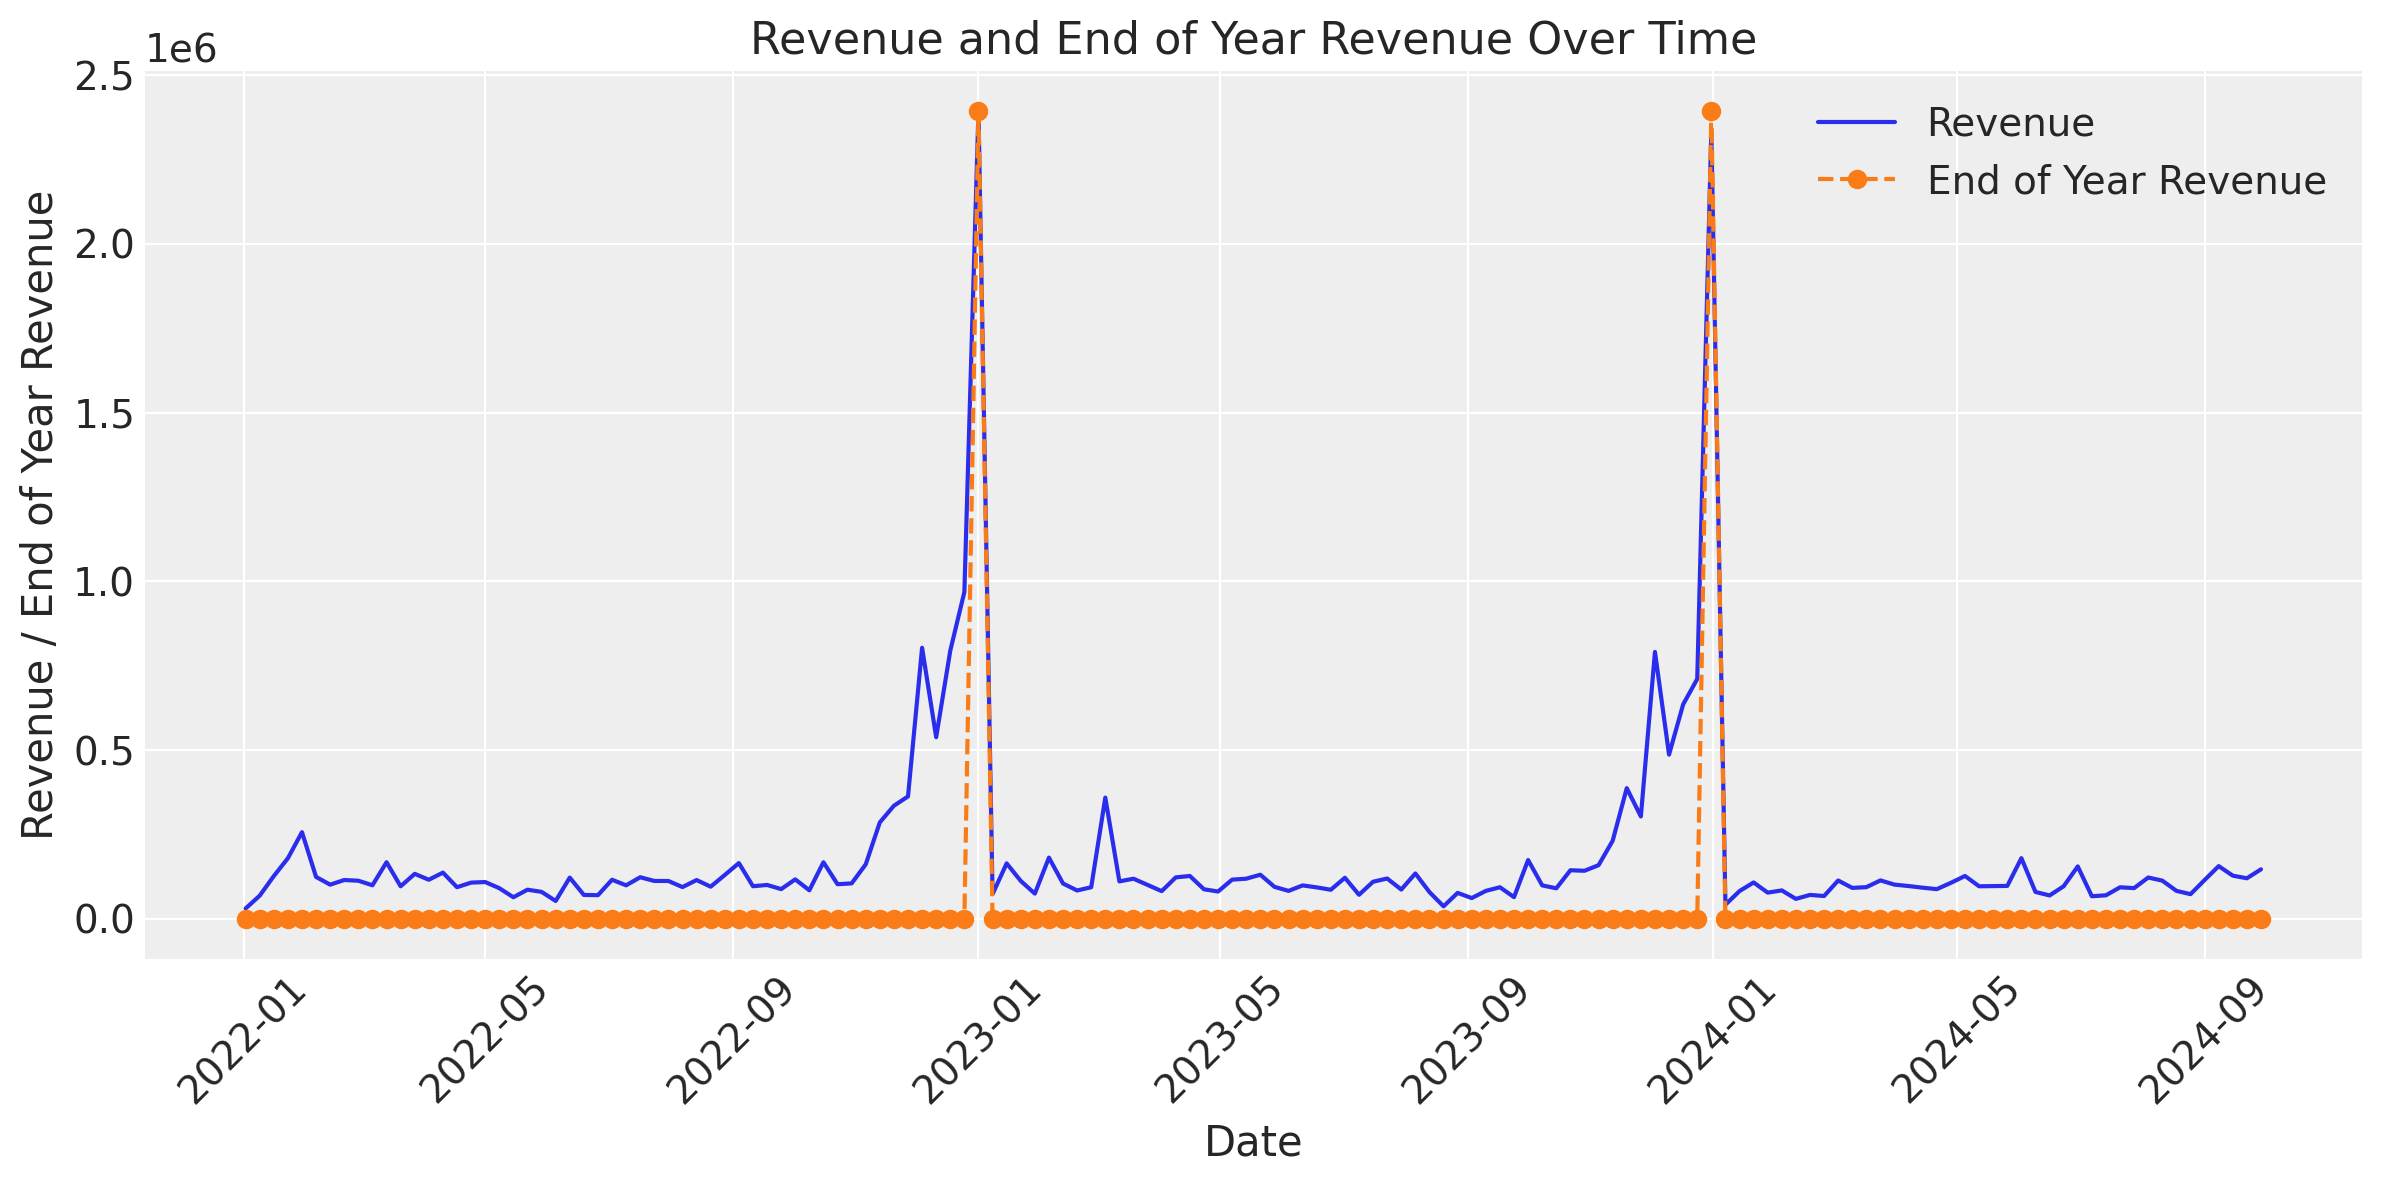

In [15]:
# prompt: generate chart with Date as x axis and revenue and end of year on y axis

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Revenue'], label='Revenue')
plt.plot(df['Date'], df['end_of_year'] * df['Revenue'].max(), label='End of Year Revenue', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue / End of Year Revenue')
plt.title('Revenue and End of Year Revenue Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
df_ = df.set_index('Date')
input_df = df_[['log_Revenue', *[c for c in df_.columns if 'Impressions' in c], 'end_of_year', 'eoy_campaign', 'giving_tuesday', 'trend']]
spend_df = df_[['Revenue', *[c for c in df_.columns if 'Spend' in c]]]

In [17]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


#df = spend_df.copy()
df = input_df.copy()
df = df.reset_index()

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [18]:
data = df.copy()
X = data.drop("log_Revenue", axis=1)
y = data["log_Revenue"]

In [19]:
data["log_Revenue"].describe()

,log_Revenue
count,144.000000
mean,11.725506
std,0.680996
min,10.336040
25%,11.372374
50%,11.571938
75%,11.787318
max,14.688350


In [20]:
data.dtypes

,0
Date,datetime64[ns]
log_Revenue,float64
Bing_Branded_Impressions,float64
Bing_NonBranded_Impressions,float64
DM_Acq_Impressions,float64
DM_Appeal_Impressions,float64
Email_Impressions,float64
FB_Impressions,float64
GoogleAds_Branded_Impressions,float64
GoogleAds_NonBranded_Impressions,float64


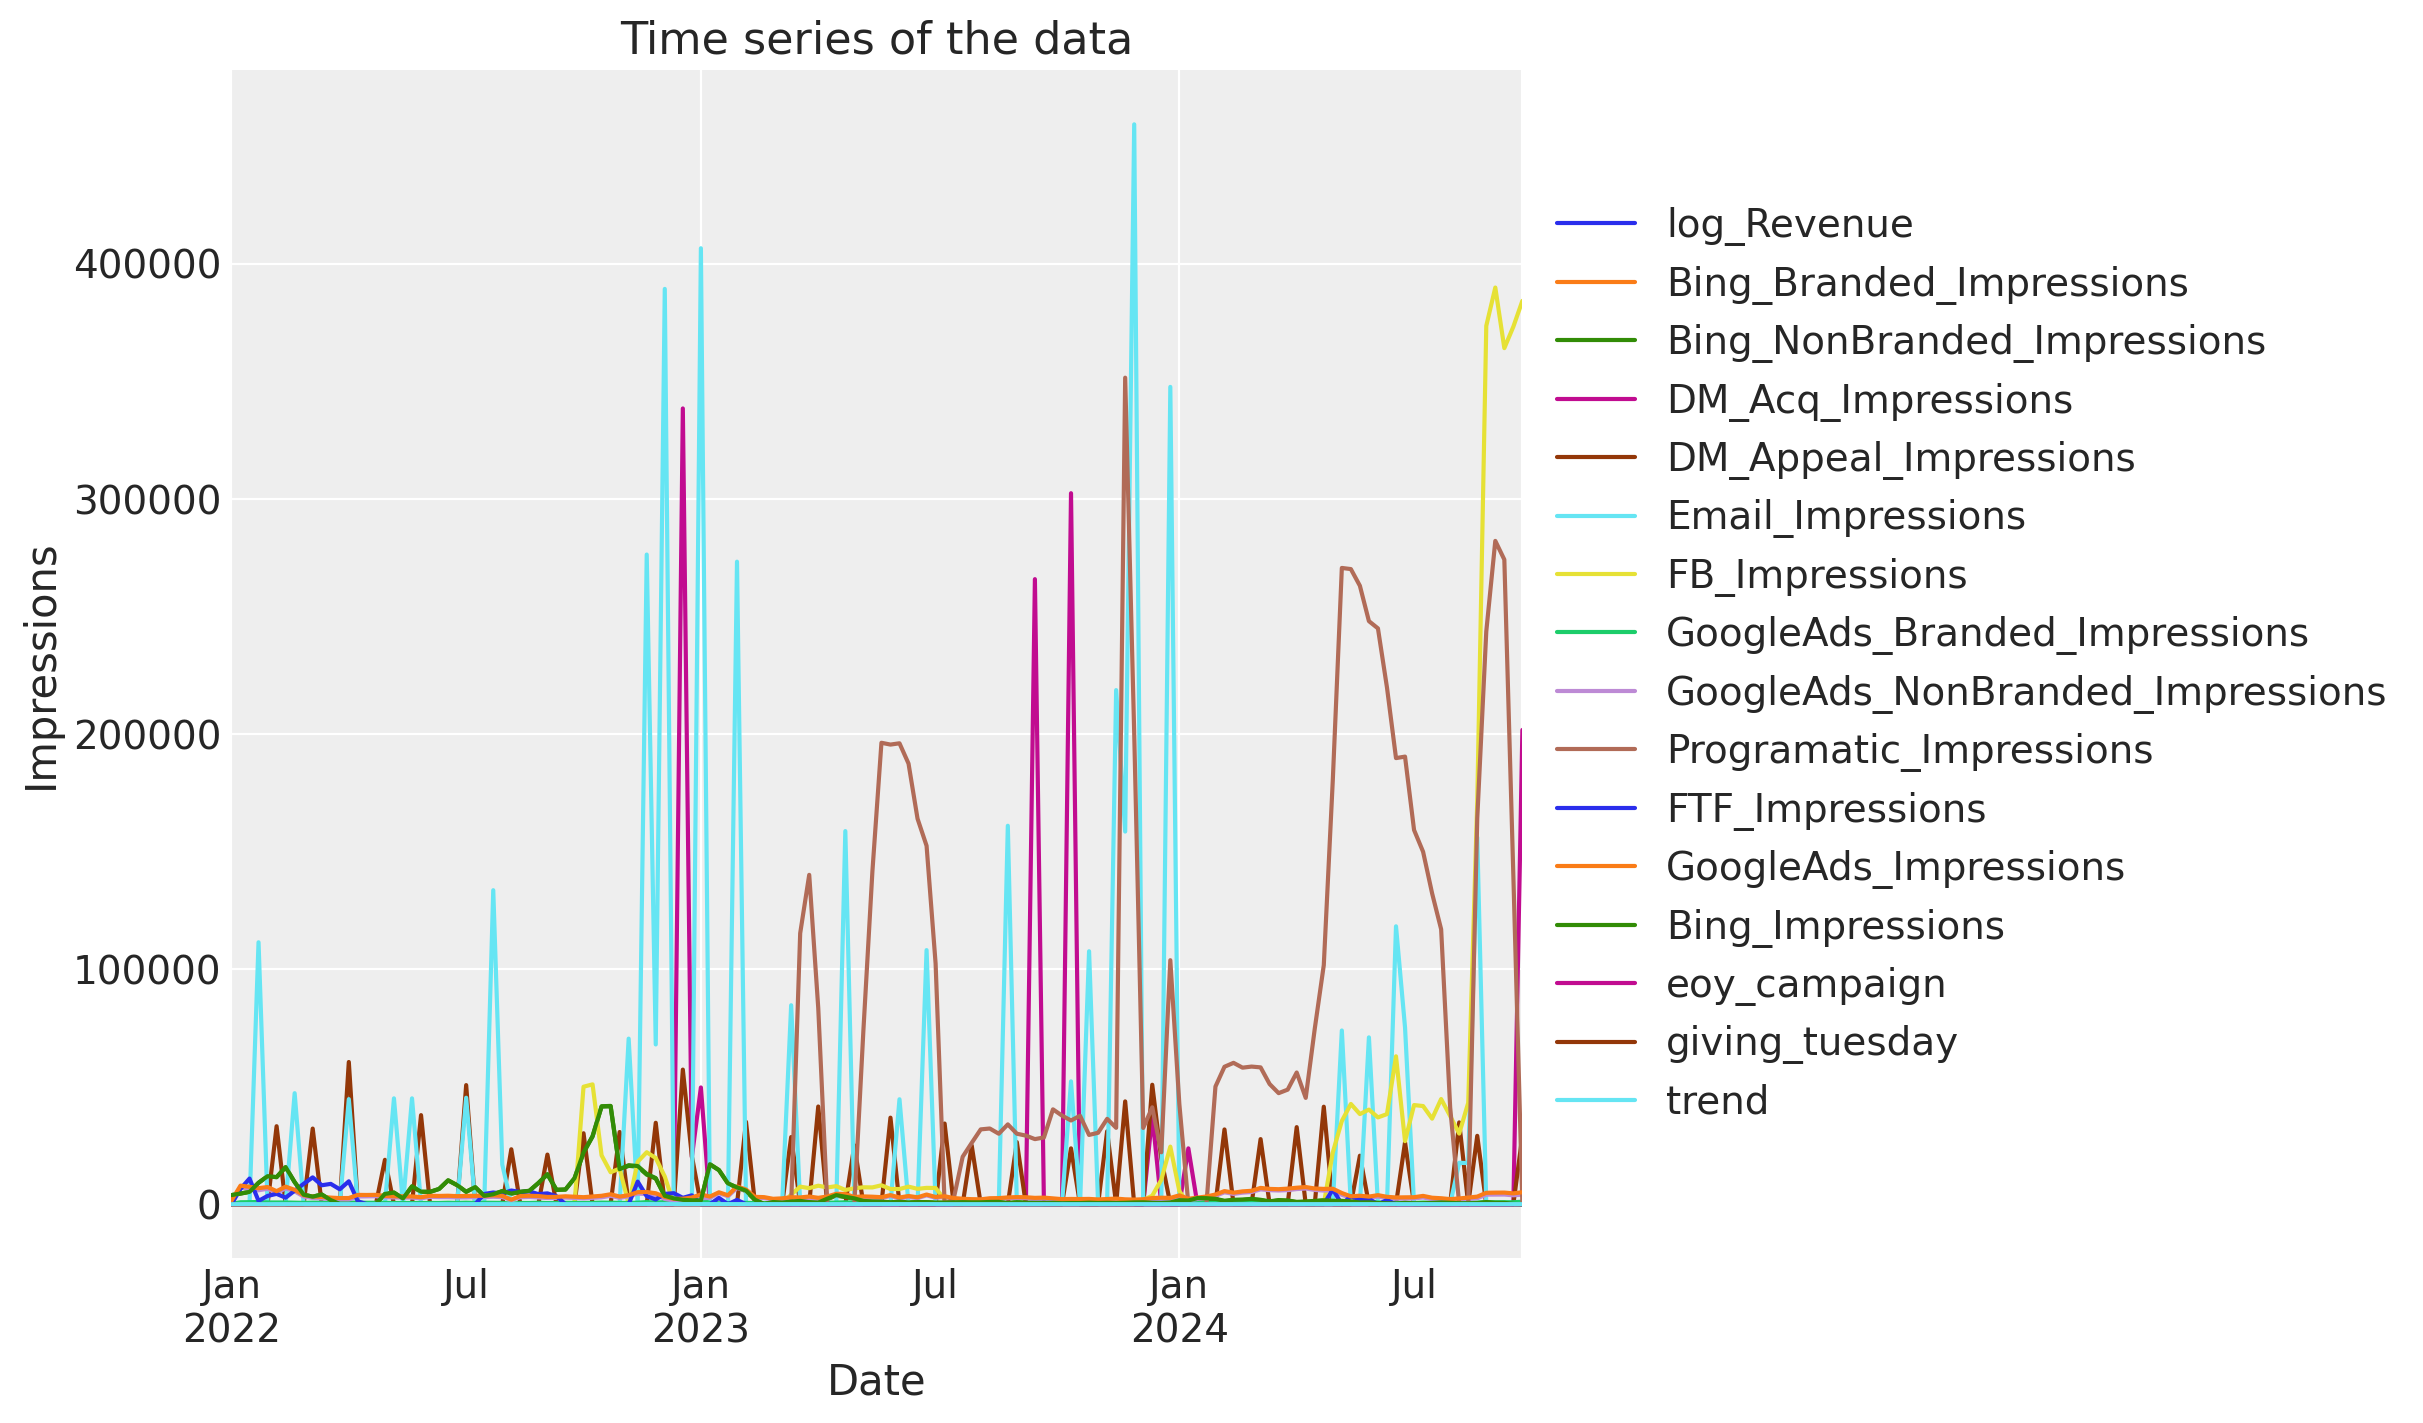

In [21]:
fig, ax = plt.subplots()
data.set_index("Date").plot(ax=ax)
ax.set_title("Time series of the data")
ax.set_ylabel("Impressions")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [22]:
X = data.drop("log_Revenue", axis=1)
y = data["log_Revenue"]

print("First few rows of X:")
print(X.head())

print("\nFirst few rows of y (should be log scale):")
print(y.head())

print("\nStatistics on y:")
print(y.describe())




First few rows of X:
        Date  Bing_Branded_Impressions  Bing_NonBranded_Impressions  \
0 2022-01-02                       1.0                       3852.0   
1 2022-01-09                      64.0                       4482.0   
2 2022-01-16                      11.0                       5217.0   
3 2022-01-23                      31.0                       9084.0   
4 2022-01-30                      19.0                      11871.0   

   DM_Acq_Impressions  DM_Appeal_Impressions  Email_Impressions  \
0                 0.0                    0.0                0.0   
1                 0.0                    0.0                0.0   
2                 0.0                    0.0                0.0   
3                 0.0                    0.0           111374.0   
4                 0.0                    0.0                0.0   

   FB_Impressions  GoogleAds_Branded_Impressions  \
0             0.0                          147.0   
1             0.0                          80

In [23]:
from pymc_marketing.prior import Prior
import pymc_marketing.mmm as mmm

In [24]:
sampler_config = {"progressbar": True}

In [58]:


custom_config = {
    "intercept": Prior("Normal", mu=11.5, sigma=1.0),

    "saturation_beta": Prior("Gamma", sigma=2, dims="channel"),
    "saturation_lam":  Prior("Gamma", alpha=2, beta=4, dims="channel"),

    # For holiday dummies on log scale:
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {
            #  eoy_campaign, end_of_year, giving_tuesday]
            "mu":    [ 1.75,   3.0,  0.75],
            "sigma": [ 0.3,   0.3,   0.2],
        },
    },


    # Fourier seasonality priors
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 2}
    },

    # Channel coefficients
    "beta_channel": {
        "dist": "Normal",
        "kwargs": {
            # Suppose you have 5 channels, with special prior for channel[0], etc.
            "mu":    [0.5, 0.00, 0.0, 0.0, 0.0],
            "sigma": [0.1, 0.05,  1.0, 1.0, 1.0]
        },
        "dims": "channel",
    },

    # Media time‐varying parameter config
    "media_tvp_config": {
        "m": 5,   # number of basis functions
        "L": 30,  # length-scale of the TVP kernel
        "eta_lam": 2,
        "ls_mu": 2,
        "ls_sigma": 5,
        "cov_func": None,
    },
}

ch = [
    'DM_Appeal_Impressions',
    'DM_Acq_Impressions',
    'Email_Impressions',
    'FB_Impressions',
    'Programatic_Impressions',
    'FTF_Impressions'
]

mmm = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=[ 'eoy_campaign', 'end_of_year', 'giving_tuesday'],
    yearly_seasonality=1,
    time_varying_media=True,
    time_varying_intercept=False
)


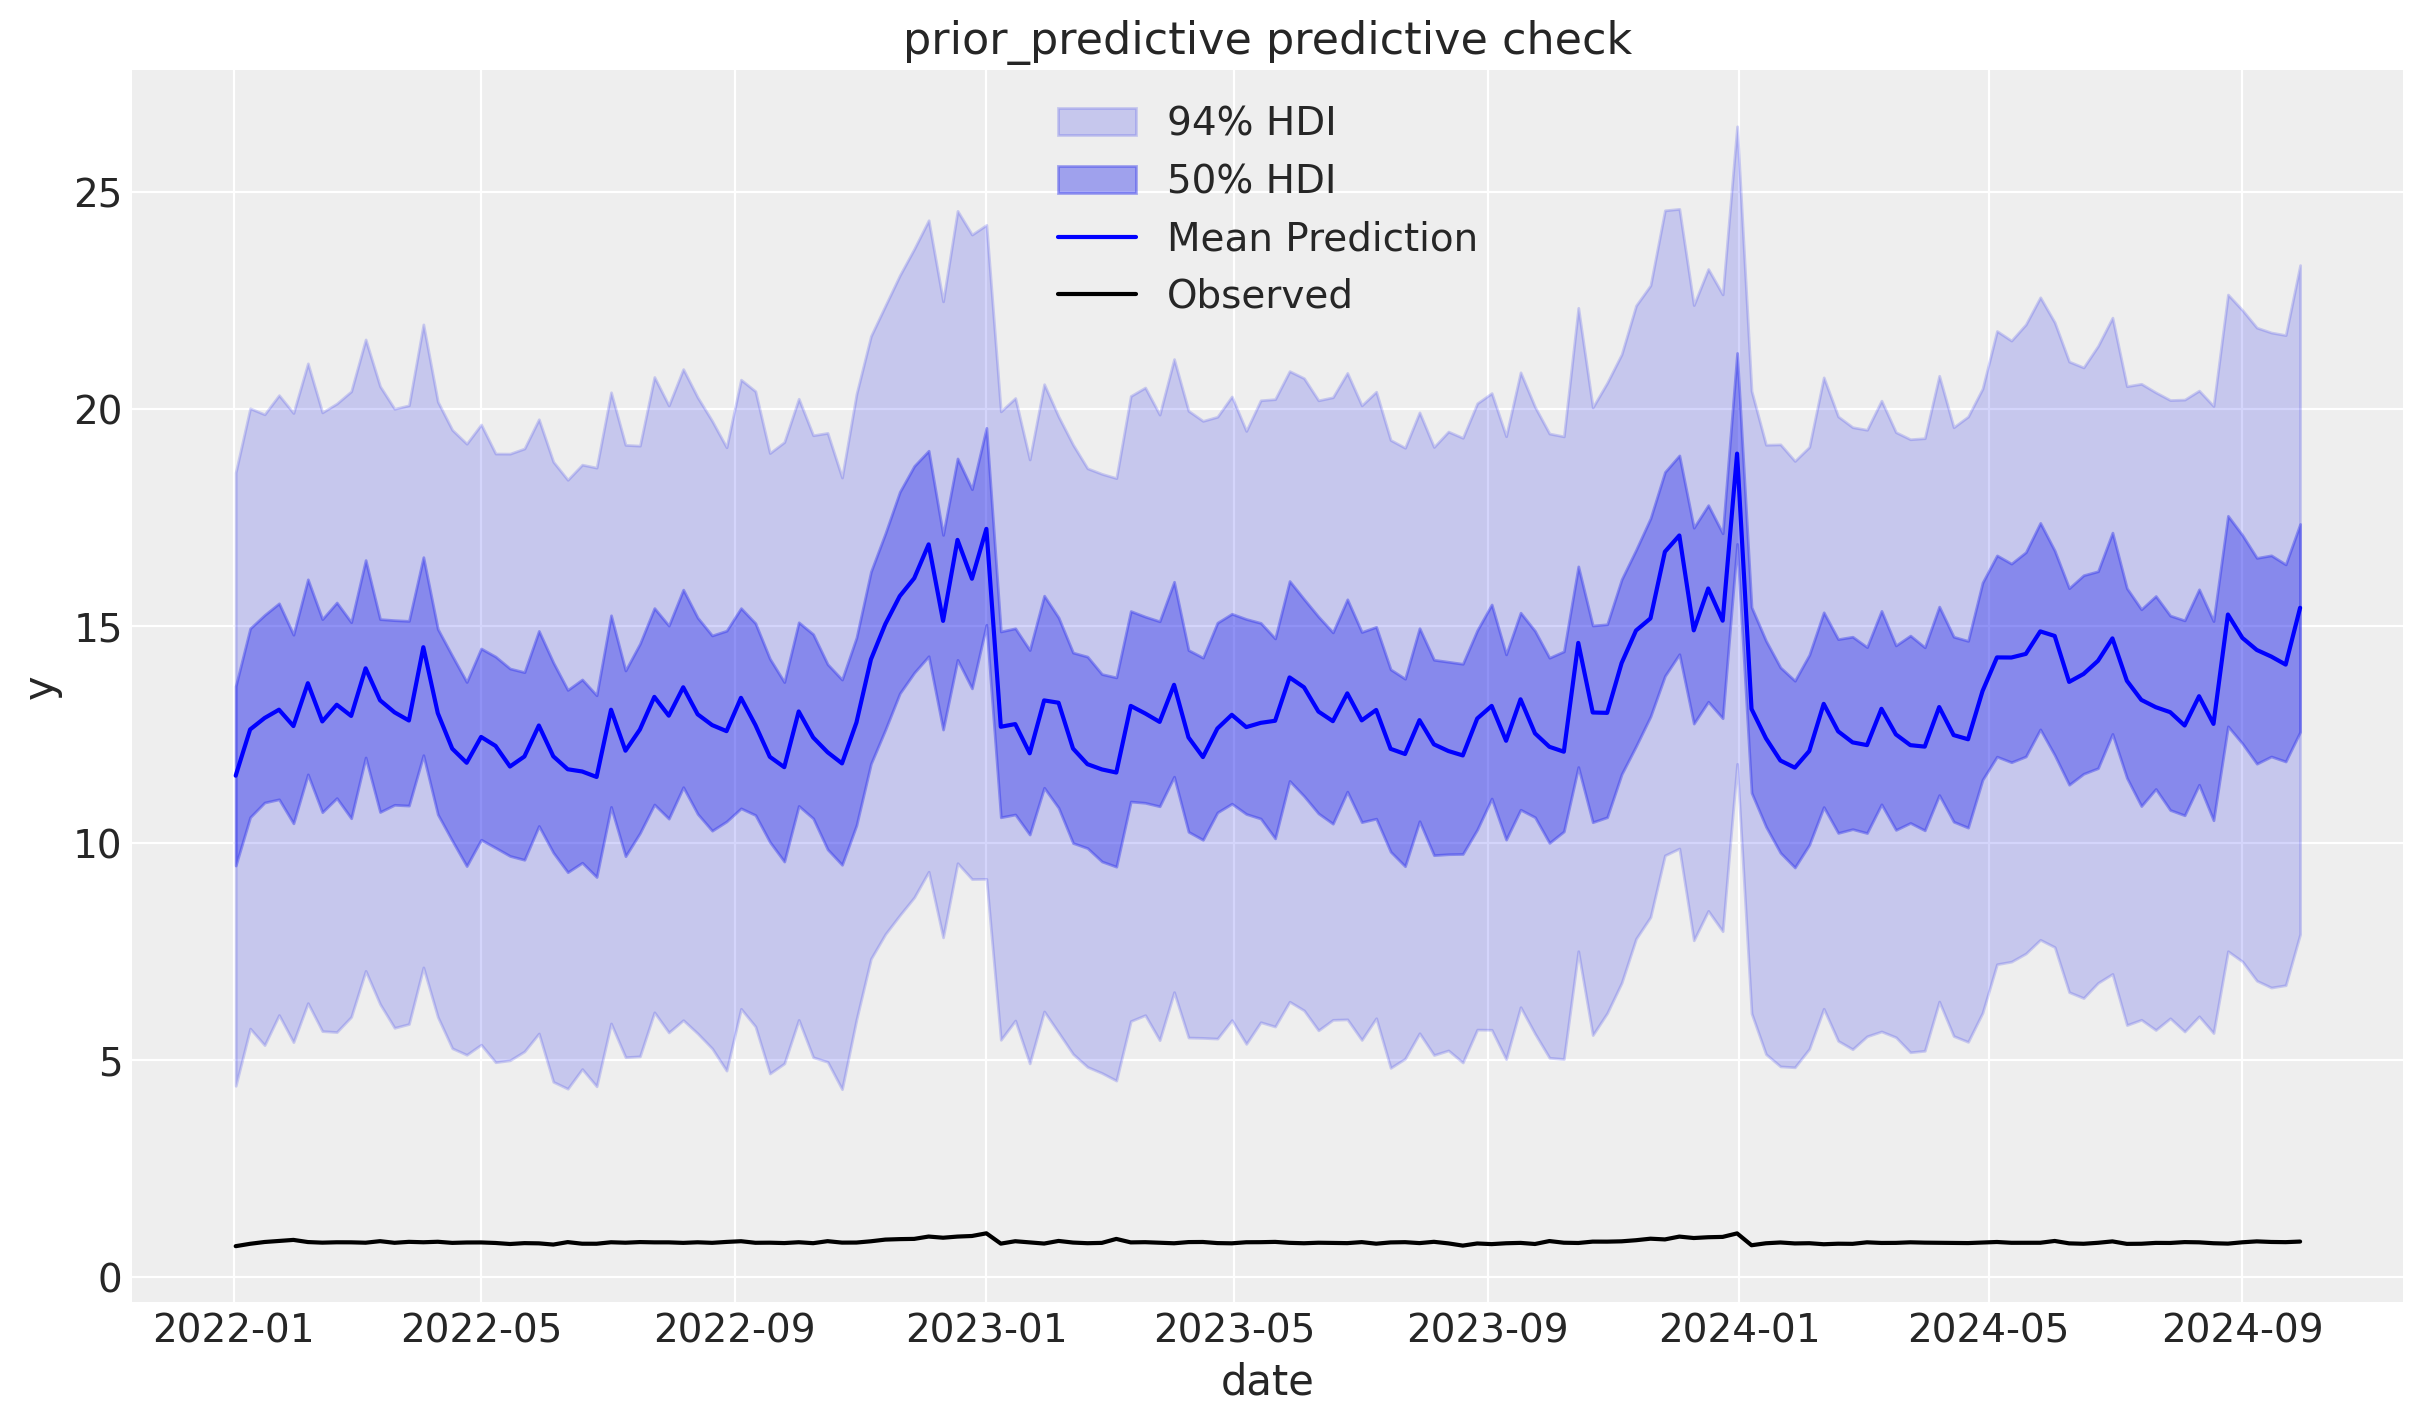

In [59]:
# Generate prior predictive samples - incorrect observed data
mmm.sample_prior_predictive(X, y, samples=6_000)

mmm.plot_prior_predictive();




In [60]:

mmm.sample_prior_predictive(X, y, samples=6000)
prior_draws = mmm.prior_predictive["y"]  # or however your MMM returns it



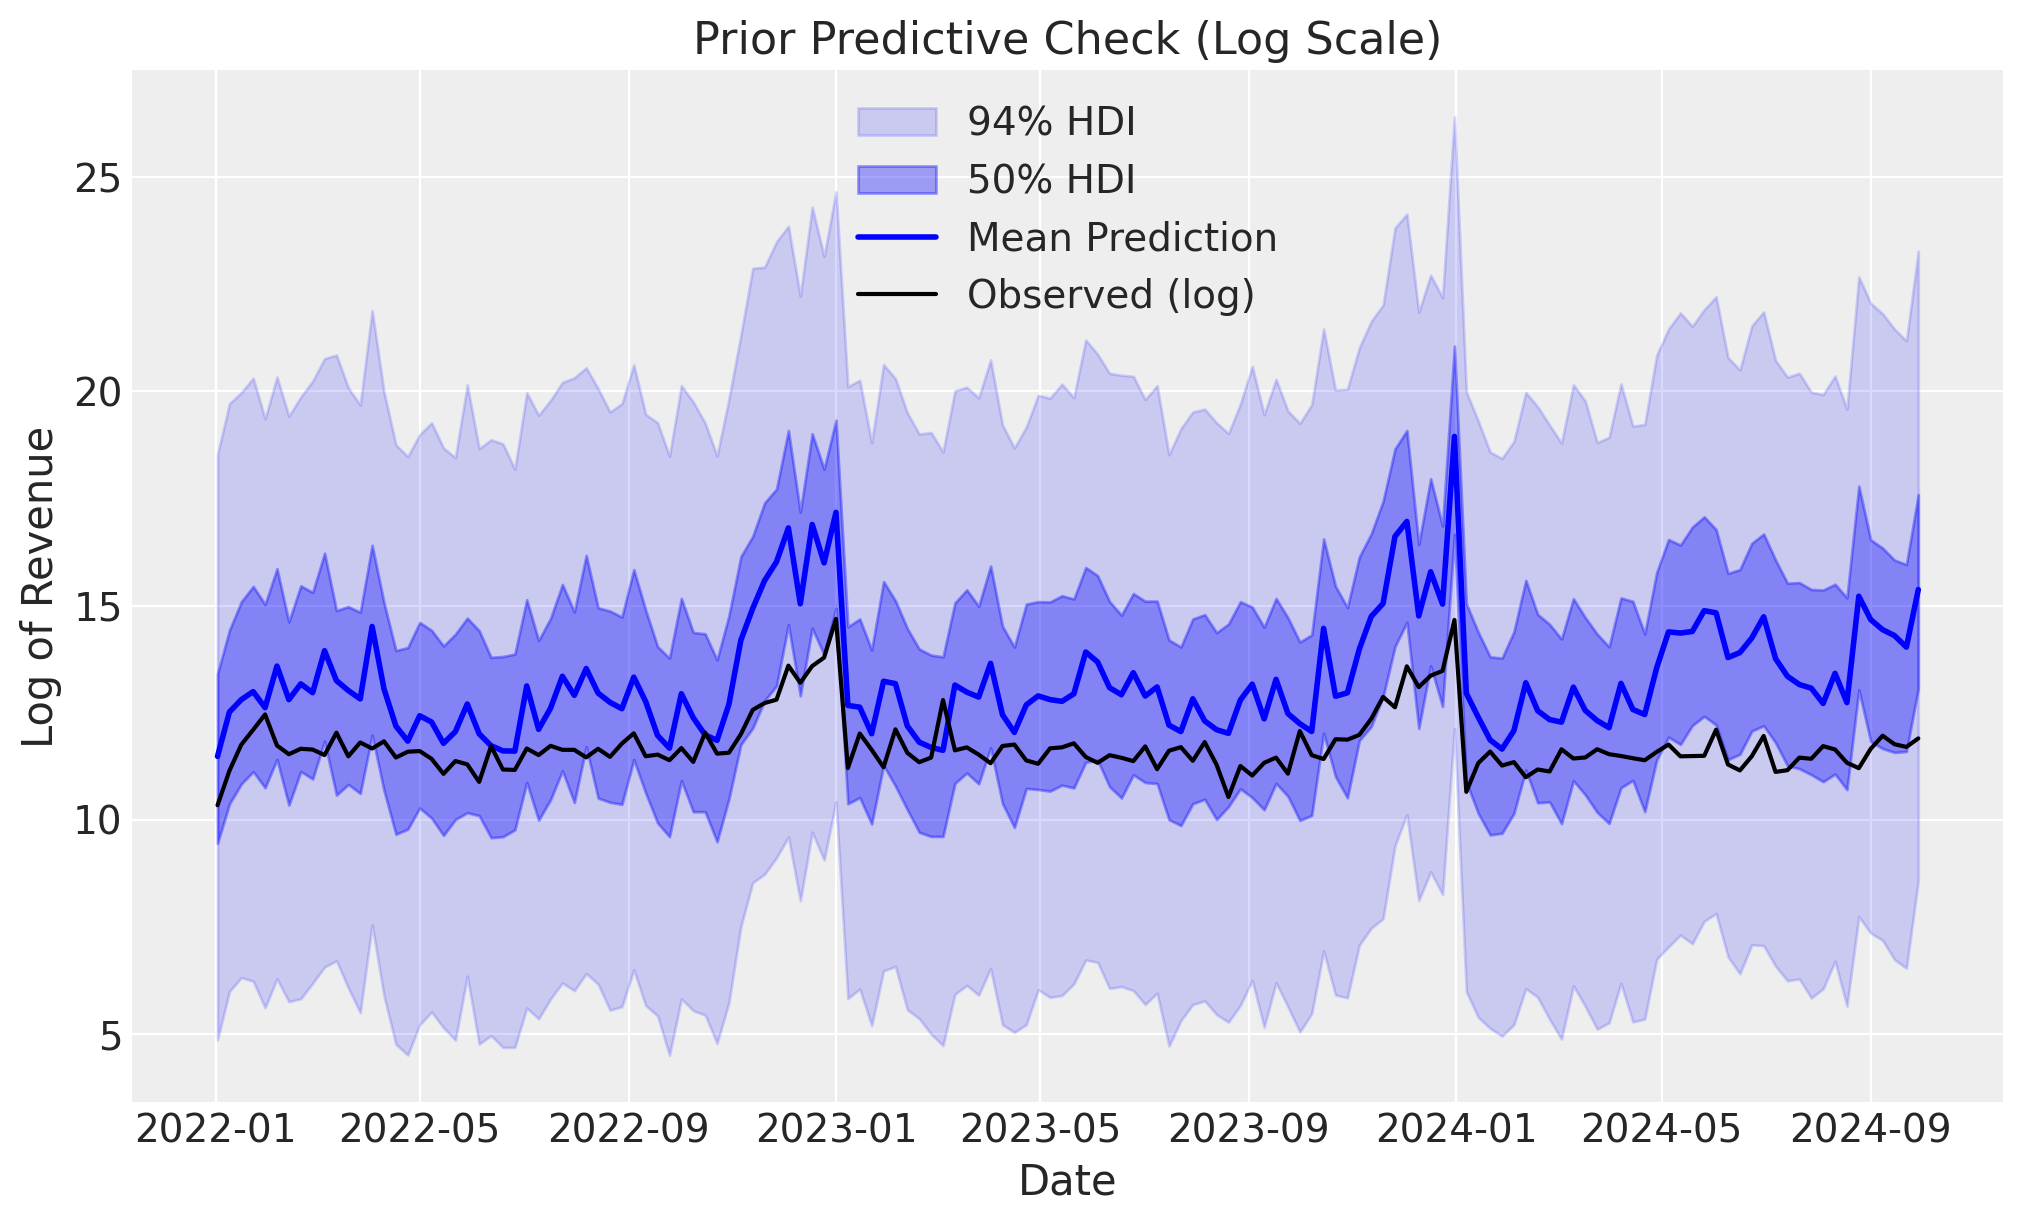

In [61]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# 1) Extract the DataArray from your MMM object
prior_da = mmm.prior_predictive["y"]  # shape (chain=1, draw=6000, date=144)

# 2) Stack chain + draw into one dimension called "sample"
#    This will give us dims ("sample", "date"), e.g. (6000, 144)
y_stacked = prior_da.stack(sample=("chain", "draw"))
# Optionally transpose so "sample" is first, "date" is second (often default already):
y_stacked = y_stacked.transpose("sample", "date")

# 3) Convert the stacked DataArray to a NumPy array
#    Now shape is (6000, 144)
y_np = y_stacked.values

# 4) Compute the mean and high-density intervals across samples
mean_pred = y_np.mean(axis=0)              # shape (144,)
hdi_94 = az.hdi(y_np, hdi_prob=0.94)       # shape (144, 2)
hdi_50 = az.hdi(y_np, hdi_prob=0.50)       # shape (144, 2)

# 5) Prepare your "dates" array, which should match length 144
dates = X["Date"].values  # or df["Date"], or prior_da.coords["date"].values

# 6) Plot the ribbons and the observed log data
plt.figure(figsize=(10, 6))

# Fill 94% HDI
plt.fill_between(dates, hdi_94[:, 0], hdi_94[:, 1],
                 color="blue", alpha=0.15, label="94% HDI")

# Fill 50% HDI
plt.fill_between(dates, hdi_50[:, 0], hdi_50[:, 1],
                 color="blue", alpha=0.35, label="50% HDI")

# Plot mean prior prediction
plt.plot(dates, mean_pred, color="blue", lw=2, label="Mean Prediction")

# Plot the log-transformed observed data
plt.plot(dates, y, color="black", label="Observed (log)")

plt.title("Prior Predictive Check (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Log of Revenue")
plt.legend()
plt.show()


In [62]:
mmm.fit(X=X, y=y, nuts_sampler="numpyro",target_accept=0.95, chains=4, draws=6_000, random_seed=rng)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

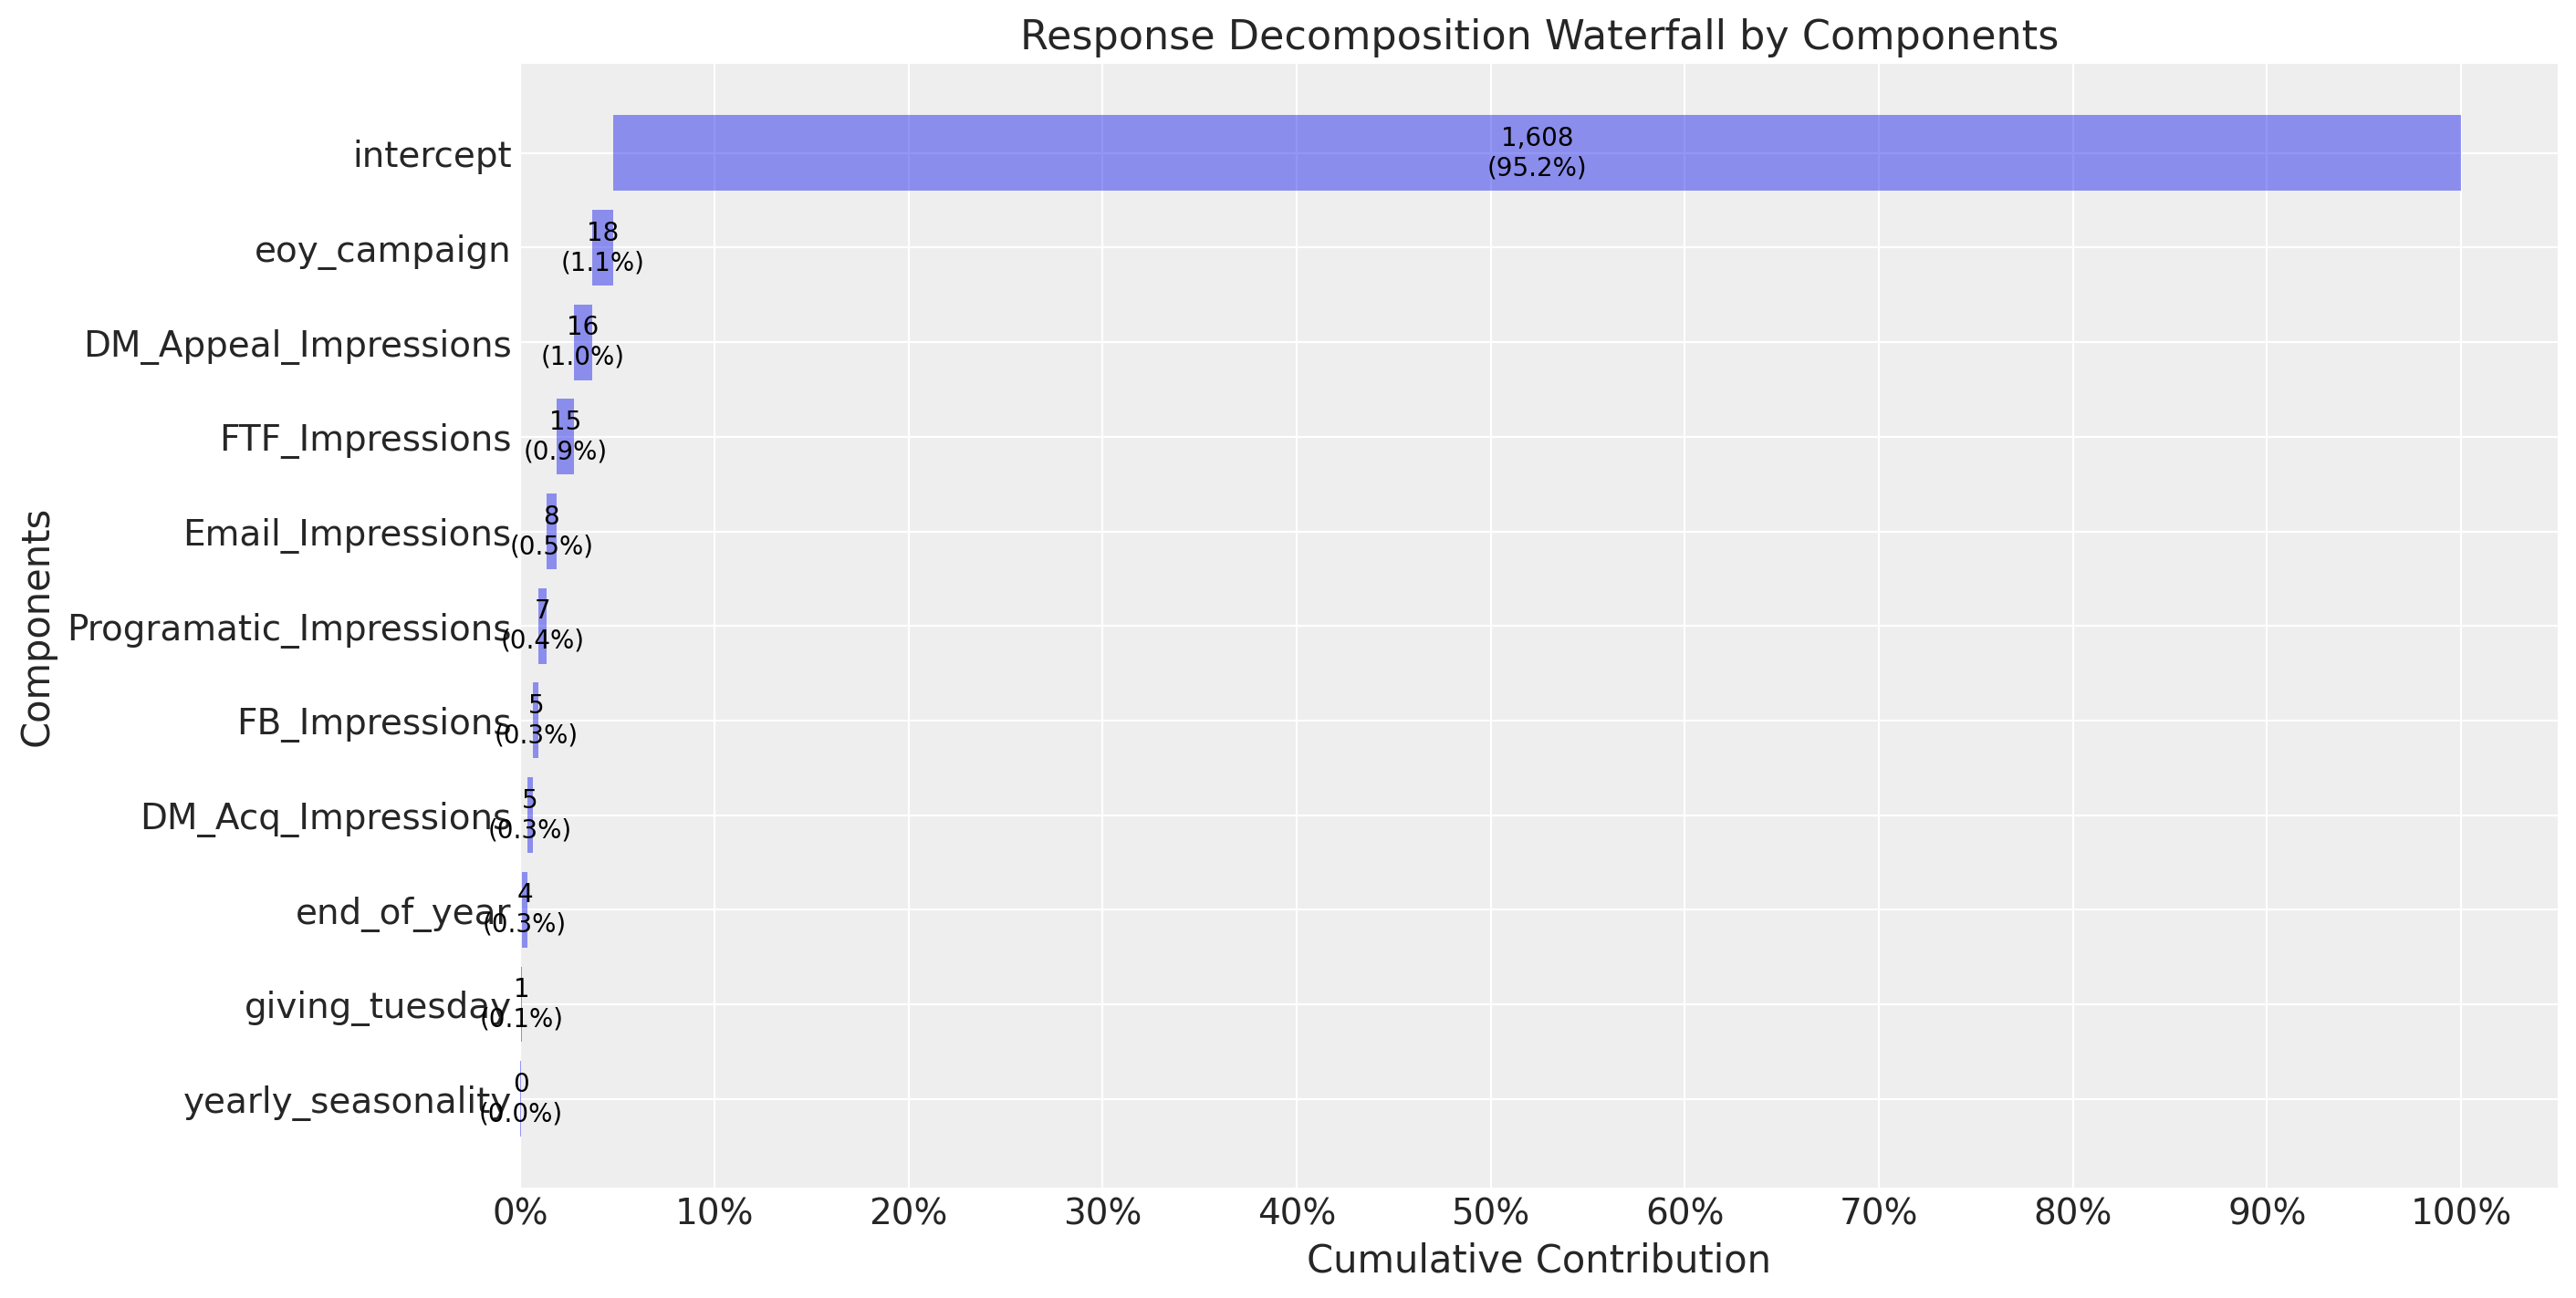

In [63]:
mmm.plot_waterfall_components_decomposition();

In [64]:
X['end_of_year'] = X['end_of_year'].astype(int)

In [65]:
from sklearn.metrics import r2_score
import numpy as np

def get_mape(mmm_, X, y):
    """
    Computes MAPE on the raw (un-logged) scale.
      mmm_    : your MMM object
      X       : features DataFrame
      y       : log-transformed target (log_Revenue)
    """
    # 1) Get log-scale predictions
    y_pred_log = mmm_.predict(X)

    # 2) Convert both y and y_pred back to raw revenue
    y_true_raw  = np.exp(y) - 1
    y_pred_raw  = np.exp(y_pred_log) - 1

    # 3) Compute MAPE in raw space
    mape = np.mean(np.abs((y_true_raw - y_pred_raw) / y_true_raw)) * 100
    print(f"MAPE: {mape:.2f}%")
    return mape

def get_r2(mmm_, X, y):
    """
    Computes R^2 on the raw (un-logged) scale.
      mmm_    : your MMM object
      X       : features DataFrame
      y       : log-transformed target (log_Revenue)
    """
    y_pred_log = mmm_.predict(X)
    y_true_raw = np.exp(y) - 1
    y_pred_raw = np.exp(y_pred_log) - 1

    r2 = r2_score(y_true_raw, y_pred_raw)
    print(f"R²: {r2:.3f}")
    return r2


In [66]:
mape_value = get_mape(mmm, X, y)
r2_value   = get_r2(mmm, X, y)


Output()

MAPE: 25.54%


Output()

R²: 0.766


Output()

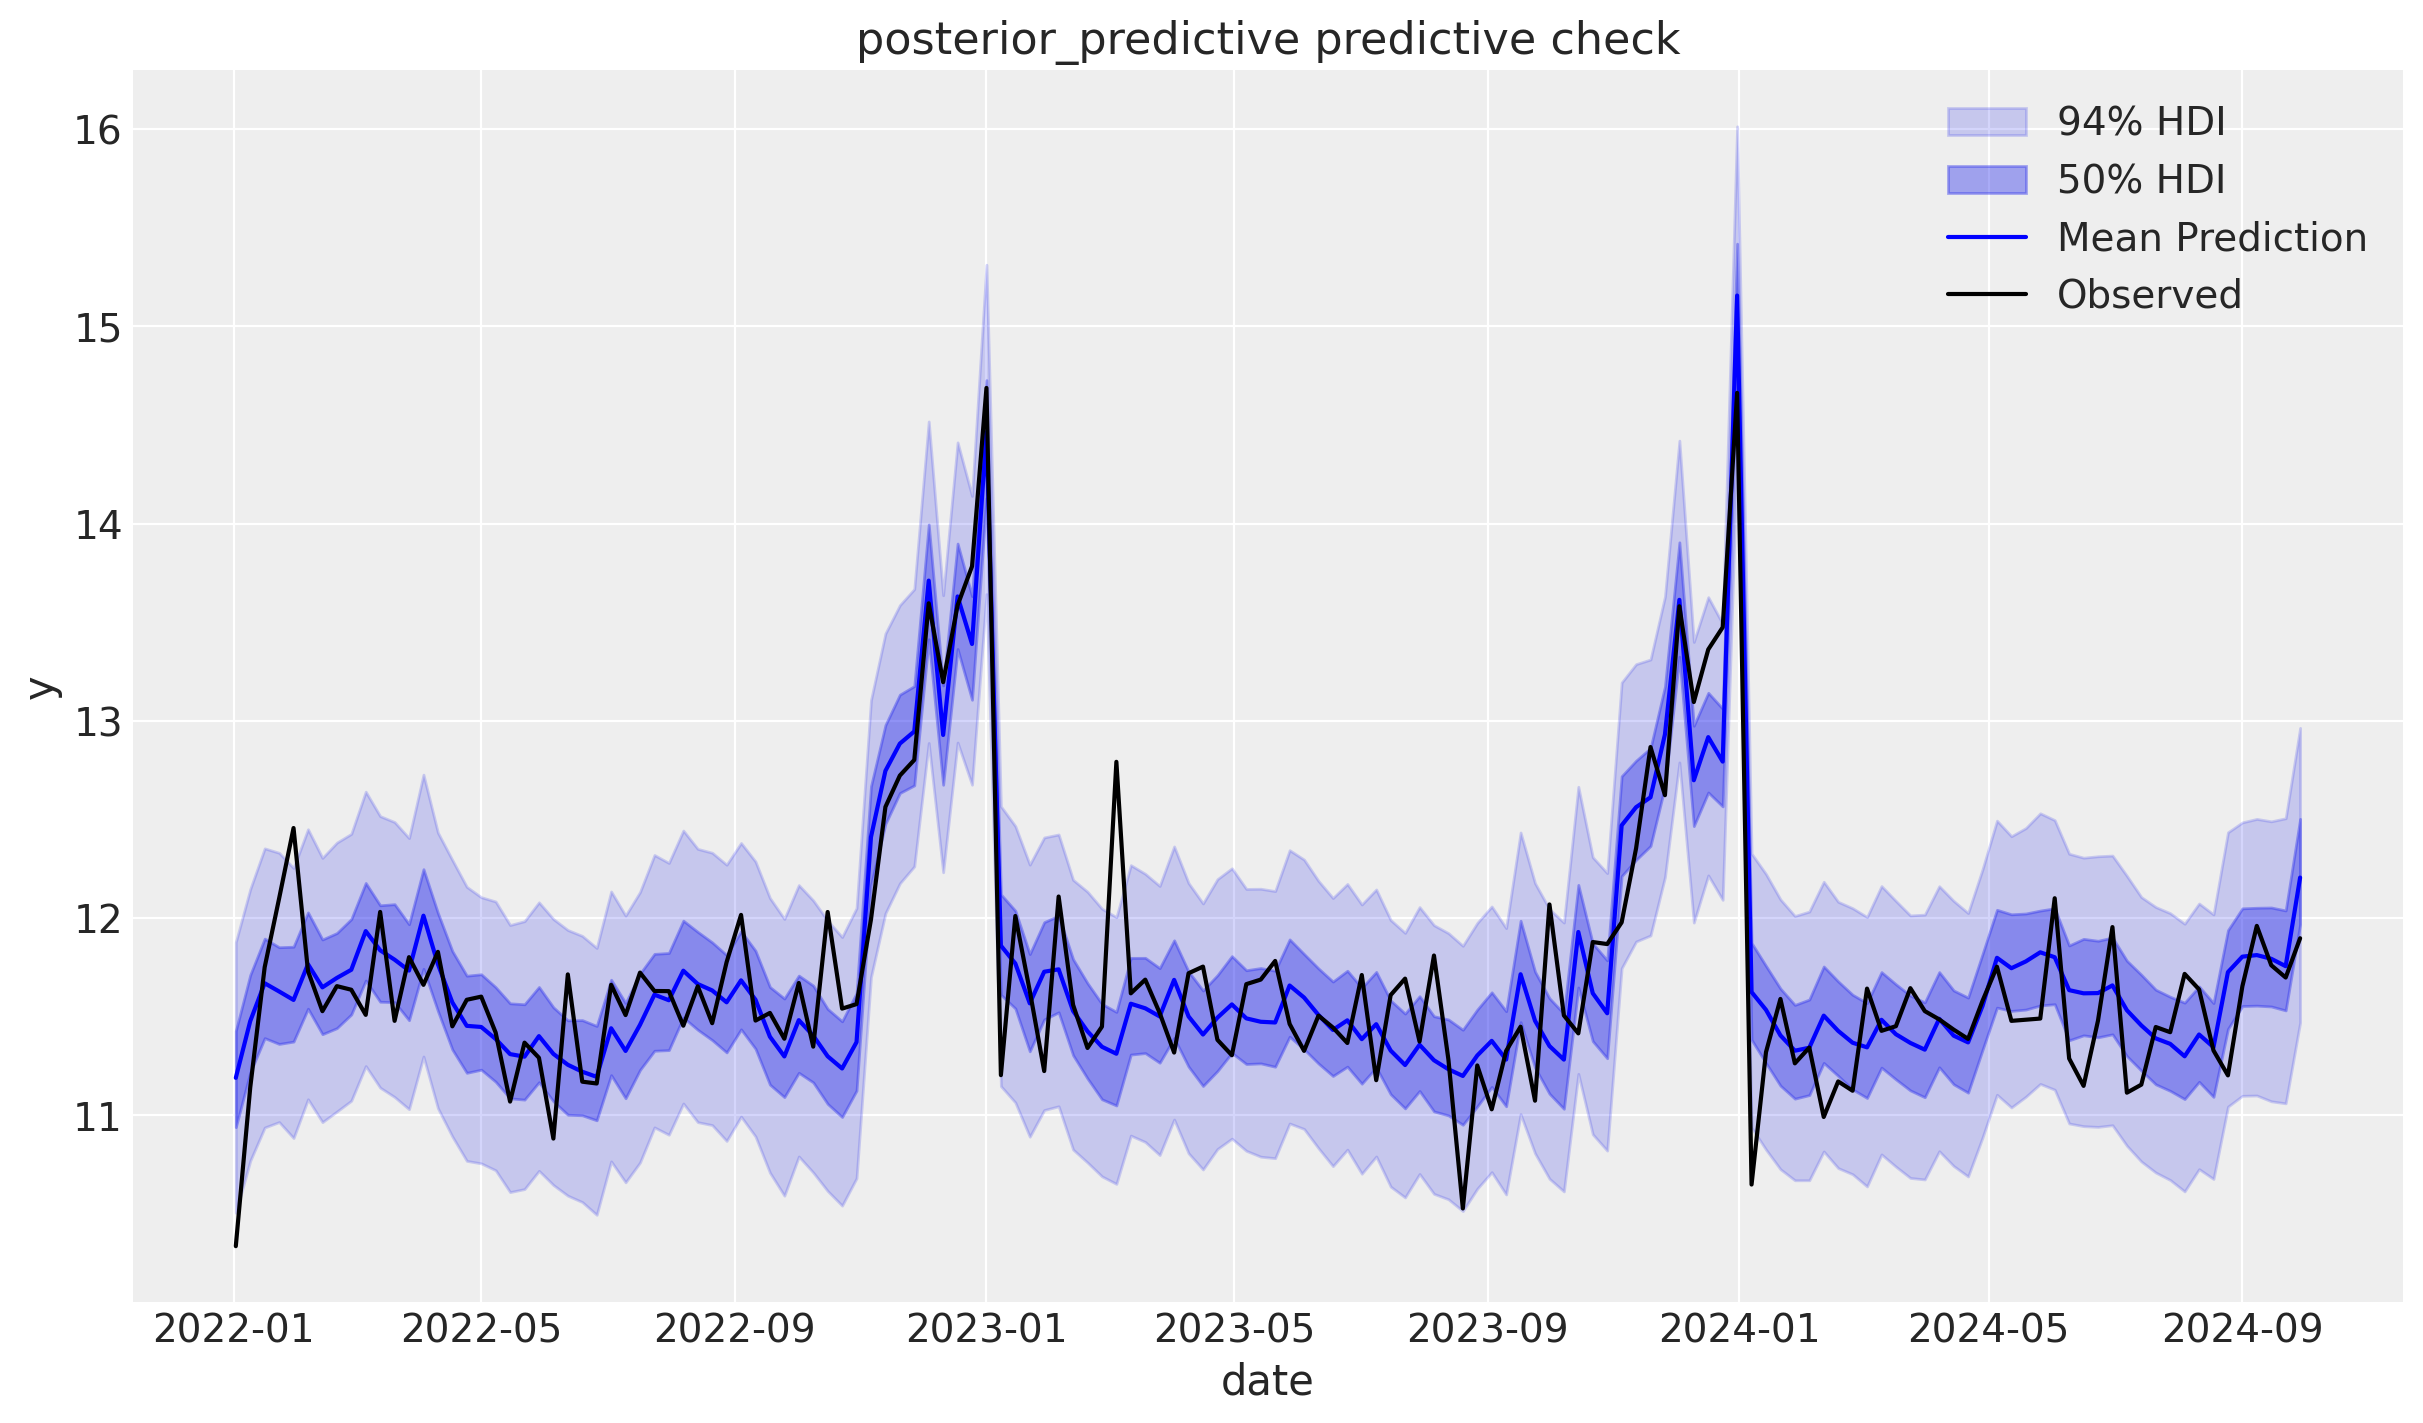

In [67]:
def get_posterior_check(mmm_):
  mmm_.sample_posterior_predictive(X, extend_idata=True, combined=True)
  mmm_.plot_posterior_predictive(original_scale=True);
get_posterior_check(mmm)

In [ ]:
stop

In [ ]:
#use these functions for raw revenue
from sklearn.metrics import r2_score

def get_mape(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"MAPE: {mape}")

def get_r2(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    r2 = r2_score(y, y_pred)
    return r2


In [ ]:
print(get_mape(mmm))
print(get_r2(mmm))

In [ ]:
def get_posterior_check(mmm_):
  mmm_.sample_posterior_predictive(X, extend_idata=True, combined=True)
  mmm_.plot_posterior_predictive(original_scale=True);

In [ ]:
get_posterior_check(mmm)

In [ ]:
df_res = df[['Date']]
df_res['y'] = y
df_res['y_pred'] = mmm.predict(X)

In [ ]:
df_res

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['y'], label='y')
plt.plot(df['Date'], df_res['y_pred'], label='y_pred', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Model Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
